In [2]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [3]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'

# config_file = data_path + "step5_prod_0.tpr"
# concat_traj_file = data_path + "prod_cat.xtc"
config_file = data_path + "conf_noloops.pdb"
concat_traj_file = data_path + "traj_noloops.xtc"


# sampled_traj_name = data_path + 'sampled_traj_each10.xtc'

In [4]:
# sampled_traj = mda.Universe(config_file, sampled_traj_name)
# sampled_traj.trajectory.n_frames
# sampled_ref_traj = mda.Universe(config_file, sampled_traj_name)
# sampled_ref_traj.trajectory[-1]

# Dendrogram

Clustering using the rmsd matrix (on the sampled trajectory) and the dendrogram, does not really work

In [5]:
# R = RMSD(sampled_traj, sampled_ref_traj, select=sel).run()
# 
# plt.title("RMSD for the trajectry aligned (reduced number of frames) on the last frame")
# plt.plot(R.results.rmsd[:,2])
# plt.xlabel('Time')
# plt.ylabel('RMSD')

In [6]:
# matrix = diffusionmap.DistanceMatrix(sampled_traj, select=sel).run()

In [7]:
# plt.imshow(matrix.results.dist_matrix, cmap='viridis')
# plt.xlabel('Frame')
# plt.ylabel('Frame')
# plt.colorbar(label=r'RMSD ($\AA$)')

In [8]:
# Z = linkage(squareform(matrix.results.dist_matrix), 'average')

In [9]:
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)

In [10]:
# cl_labels = fcluster(Z, t=4, criterion='maxclust')

In [11]:
# rmsd_arr = R.results.rmsd
# plt.plot(rmsd_arr[cl_labels == 1][:, 1], rmsd_arr[cl_labels == 1][:, 2], '.')
# plt.plot(rmsd_arr[cl_labels == 2][:, 1], rmsd_arr[cl_labels == 2][:, 2], '.')
# plt.plot(rmsd_arr[cl_labels == 3][:, 1], rmsd_arr[cl_labels == 3][:, 2], '.')
# plt.title("rmsd clustered")
# plt.show()

# Clustering using dbscan

At first i am going to perform a pca, in order to reduce the dimensionality(it usually results in better clustering)

In [12]:
aligned_traj = mda.Universe(config_file, concat_traj_file) # taking the full traj

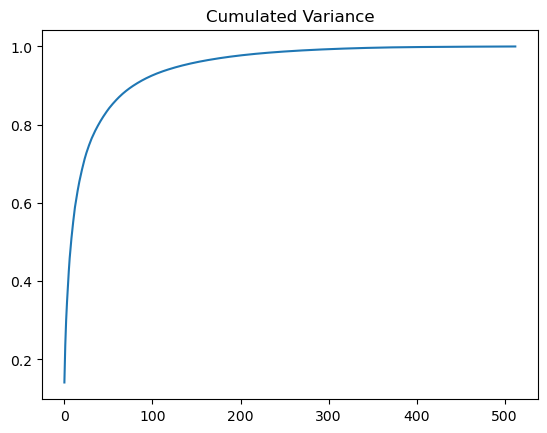

In [13]:
pca = PCA(aligned_traj, select=sel)
pca.run()

plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [14]:
# print([i for i in enumerate(pca.results.cumulated_variance)])

In [15]:
n_comp_90perc = 71

## Looking at the 2 component case, just to check for parameters and so on

In [16]:
# pca_space_2 = pca.transform(aligned_traj.select_atoms(sel),2)

In [17]:
# def genscore(i, j):
#     mcs = i + 2
#     eps = j / 10 
#     clust = HDBSCAN(min_cluster_size = mcs,
#                 cluster_selection_epsilon = eps)
#     labels = clust.fit_predict(pca_space_2)
#     return metrics.silhouette_score(pca_space_2, labels, metric = 'euclidean')

In [18]:
# num = 20
# sscore = np.zeros((num, num))
# for i in range(num):
#     for j in range(num):
#         print(i,j)
#         sscore[i,j] = genscore(i,j)

In [19]:
# plt.imshow(sscore, cmap='viridis')
# plt.colorbar()

In [20]:
# i want to keep the two big blobs separated
# opt_mcs = 11
# opt_eps = 0.5
# clust = HDBSCAN(min_cluster_size = opt_mcs,
#                 cluster_selection_epsilon = opt_eps)
# labels = clust.fit_predict(pca_space_2)

In [21]:
# plt.title("First two components of PCA")
# scatter = plt.scatter(pca_space_2[:, 0], pca_space_2[:, 1], c=labels)
# plt.xlabel("component 1 [nm]")
# plt.ylabel("component 2 [nm]")
# plt.colorbar(scatter, label = 'Color Intensity')

# 10 components, capturing 60 % of the variance

In [22]:
pca_space = pca.transform(aligned_traj.select_atoms(sel),6)

In [23]:
def genscore(i, j):
    mcs = i + 2
    eps = j / 10 
    clust = HDBSCAN(min_cluster_size = mcs,
                cluster_selection_epsilon = eps)
    # clust = KMeans(n_clusters = i + 2)
    labels = clust.fit_predict(pca_space)
    return metrics.silhouette_score(pca_space, labels, metric = 'euclidean')

In [24]:
# num = 20
# sscore = np.zeros((num,num))
# for i in range(num):
#     for j in range(num):
#         sscore[i,j] = genscore(i,j)

In [25]:
# plt.imshow(sscore, cmap='viridis')
# plt.colorbar()

[-1  0  1]


Text(0, 0.5, 'component 2 $[\\AA]$')

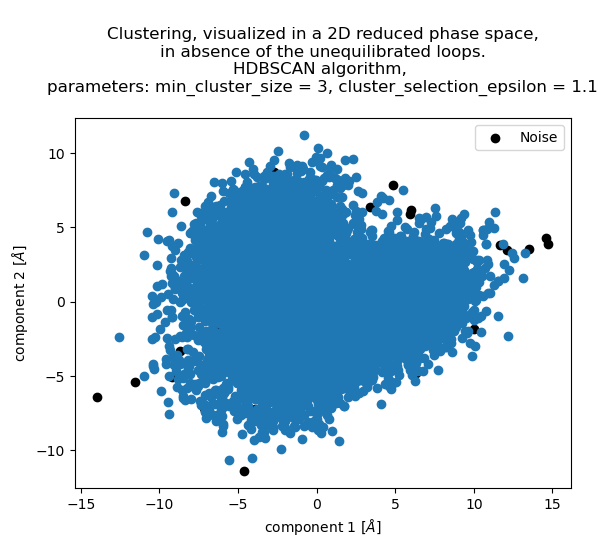

In [33]:
opt_mcs = 3
opt_eps = 1.1
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)

labels = clust.fit_predict(pca_space)
print(np.unique(labels))
title = r"""
Clustering, visualized in a 2D reduced phase space,
in absence of the unequilibrated loops.
HDBSCAN algorithm, 
parameters: min_cluster_size = 3, cluster_selection_epsilon = 1.1
"""
plt.title(title)
scatter = plt.scatter(pca_space[:, 0][labels==-1], pca_space[:, 1][labels==-1], color = "black", label = "Noise")
scatter = plt.scatter(pca_space[:, 0][labels==0], pca_space[:, 1][labels==0])
scatter = plt.scatter(pca_space[:, 0][labels==1], pca_space[:, 1][labels==1])
scatter = plt.scatter(pca_space[:, 0][labels==2], pca_space[:, 1][labels==2])
plt.legend()
plt.xlabel(r"component 1 $[\AA]$")
plt.ylabel(r"component 2 $[\AA]$")

In [27]:
rmsd_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/03_analyzed/rmsd.csv"
rmsd = np.loadtxt(rmsd_file, delimiter = ",", skiprows = 1)

Text(0.5, 1.0, '\nClustering, visualized on the RMSD\nHDBSCAN algorithm, \nparameters: min_cluster_size = 4, cluster_selection_epsilon = 1.1,\nsilhouette score $\\approx 0.05$ \n')

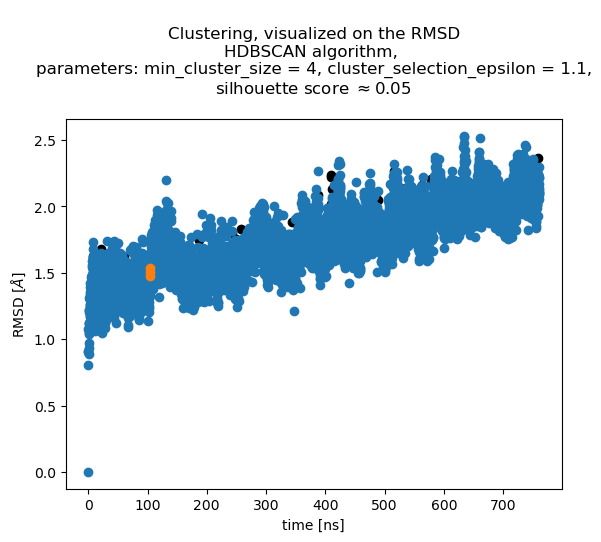

In [28]:
plt.scatter(rmsd[:, 0][labels == -1] / 10, rmsd[:, 1][labels == -1], color = "black", label = "Noise")
plt.scatter(rmsd[:, 0][labels == 0] / 10, rmsd[:, 1][labels == 0])
plt.scatter(rmsd[:, 0][labels == 1] / 10, rmsd[:, 1][labels == 1])
plt.scatter(rmsd[:, 0][labels == 2] / 10, rmsd[:, 1][labels == 2])
title = r"""
Clustering, visualized on the RMSD
HDBSCAN algorithm, 
parameters: min_cluster_size = 4, cluster_selection_epsilon = 1.1,
silhouette score $\approx 0.05$ 
"""
plt.xlabel("time [ns]")
plt.ylabel(r"RMSD $[\AA]$")
plt.title(title)

[-1  0  1]


Text(0, 0.5, 'component 2 $[\\AA]$')

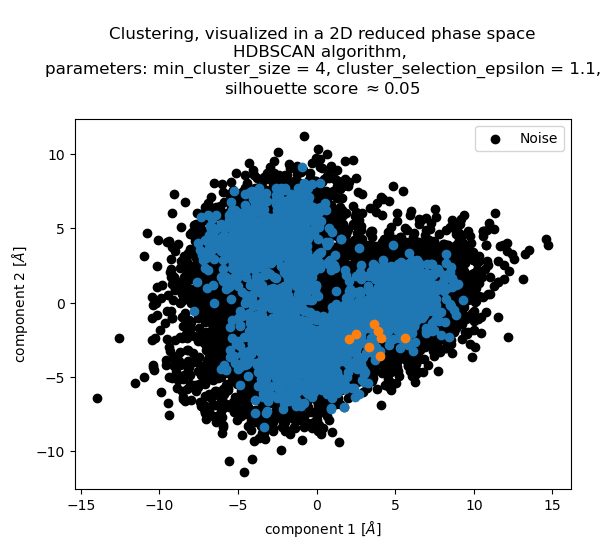

In [29]:
opt_mcs = 7
opt_eps = 1.1
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)

labels = clust.fit_predict(pca_space)
print(np.unique(labels))
title = r"""
Clustering, visualized in a 2D reduced phase space
HDBSCAN algorithm, 
parameters: min_cluster_size = 4, cluster_selection_epsilon = 1.1,
silhouette score $\approx 0.05$ 
"""
plt.title(title)
scatter = plt.scatter(pca_space[:, 0][labels==-1], pca_space[:, 1][labels==-1], color = "black", label = "Noise")
scatter = plt.scatter(pca_space[:, 0][labels==0], pca_space[:, 1][labels==0])
scatter = plt.scatter(pca_space[:, 0][labels==1], pca_space[:, 1][labels==1])
scatter = plt.scatter(pca_space[:, 0][labels==2], pca_space[:, 1][labels==2])
plt.legend()
plt.xlabel(r"component 1 $[\AA]$")
plt.ylabel(r"component 2 $[\AA]$")

Text(0.5, 1.0, '\nClustering, visualized on the RMSD\nHDBSCAN algorithm, \nparameters: min_cluster_size = 4, cluster_selection_epsilon = 1.1,\nsilhouette score $\\approx 0.05$ \n')

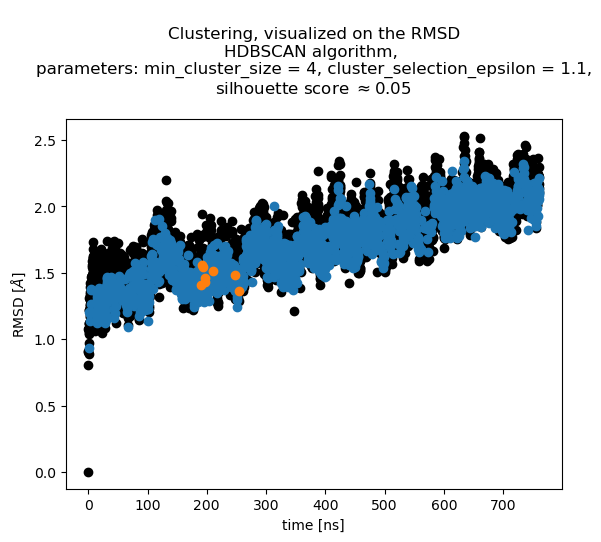

In [30]:
plt.scatter(rmsd[:, 0][labels == -1] / 10, rmsd[:, 1][labels == -1], color = "black", label = "Noise")
plt.scatter(rmsd[:, 0][labels == 0] / 10, rmsd[:, 1][labels == 0])
plt.scatter(rmsd[:, 0][labels == 1] / 10, rmsd[:, 1][labels == 1])
plt.scatter(rmsd[:, 0][labels == 2] / 10, rmsd[:, 1][labels == 2])
title = r"""
Clustering, visualized on the RMSD
HDBSCAN algorithm, 
parameters: min_cluster_size = 4, cluster_selection_epsilon = 1.1,
silhouette score $\approx 0.05$ 
"""
plt.xlabel("time [ns]")
plt.ylabel(r"RMSD $[\AA]$")
plt.title(title)

# I can look at the two different clusters

In [31]:
first100_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_first100ns.xtc"
from100_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_from100ns.xtc"
last_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_lastns.xtc"
first100_traj = mda.Universe(config_file, first100_file) # taking the full traj
from100_traj = mda.Universe(config_file, from100_file) # taking the full traj
last_traj = mda.Universe(config_file, last_file) # taking the full traj

ValueError: The topology and XTC trajectory files don't have the same number of atoms!
Topology number of atoms 36026
Trajectory: /home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_first100ns.xtc Number of atoms 36267

In [ ]:
RF_first = RMSF(first100_traj.select_atoms(sel)).run()
RF_from = RMSF(from100_traj.select_atoms(sel)).run()
RF_last = RMSF(last_traj.select_atoms(sel)).run()


# plt.title('RMSF of the trajectory aligned on the last frame, first100')
# plt.plot(RF_first.results.rmsf)
# plt.xlabel('Residue ID')
# plt.ylabel('RMSF')
# plt.show()
# plt.title('RMSF of the trajectory aligned on the last frame, from100')
# plt.plot(RF_from.results.rmsf)
# plt.xlabel('Residue ID')
# plt.ylabel('RMSF')
# plt.show()
# plt.title('RMSF of the trajectory aligned on the last frame, last')
# plt.plot(RF_last.results.rmsf)
# plt.xlabel('Residue ID')
# plt.ylabel('RMSF')
# plt.show()

plt.title('RMSF of the two clusters found in the trajectory')
# plt.plot(RF_first.results.rmsf, label = "first")
plt.plot(RF_from.results.rmsf, label = "0-525 ns")
plt.plot(RF_last.results.rmsf, label = "525-562 ns")
plt.legend()
plt.xlabel('Residue ID')
plt.ylabel(r'RMSF $[\AA]$')
plt.show()